In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import dates
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)
plt.rcParams.update({'figure.facecolor': 'white'})

### Carregamento dos dados para análise

In [3]:
df = pd.read_csv('vacinacao_ZonaDaMata.csv', dtype={'paciente_endereco_coMunicipio': str})

In [4]:
def load_data_vac(df):
    
    pop = pd.read_csv('GEOinfo/POP_2021.csv', sep=';', dtype={'COD. MUNIC': str})
    pop.columns = [x.strip() for x in pop.columns]
    pop = pop[pop['COD. UF']==31]
    pop['POPULAÇÃO ESTIMADA'] = [x.replace('.','') for x in pop['POPULAÇÃO ESTIMADA']]
    pop['POPULAÇÃO ESTIMADA'] = pop['POPULAÇÃO ESTIMADA'].astype(int)
    pop['COD. MUNIC'] = [(x[0]+x[1])[:-1] for x in zip(pop['COD. UF'].astype(str), pop['COD. MUNIC'])]
    df = pd.merge(df, pop, left_on='paciente_endereco_coMunicipio', right_on='COD. MUNIC')\
                            .drop(['COD. UF', 'NOME DO MUNICÍPIO', 'UF', 'Nome da Mesoregião',
                                   'paciente_endereco_coMunicipio', 'Código IBGE do Município'], axis=1)
    
    return df

In [5]:
def data_format(df):
    df['vacina_dataAplicacao'] = pd.to_datetime(df['vacina_dataAplicacao'])
    #para diminuir as categorias das doses, mas sem certeza se foram agrupadas corretamente
    df['vacina_descricao_dose'] = ['1º Reforço' if (x=='Reforço') or (x=='3ª Dose') 
                              else x for x in df['vacina_descricao_dose']]

    dummies_dose = pd.get_dummies(df['vacina_descricao_dose'])
    df = pd.concat([df, dummies_dose[['1ª Dose', '1º Reforço', '2ª Dose', '2º Reforço', 'Única']]], axis=1)
    
    return df

In [20]:
def analise_municipio(df, municipio):
    
    df_municipio = df[(df['paciente_endereco_nmMunicipio']==municipio)]
    df_municipio = df_municipio.groupby(['vacina_dataAplicacao']).sum()\
                [['1ª Dose', '1º Reforço', '2ª Dose', '2º Reforço', 'Única']]
    hab = df[df['paciente_endereco_nmMunicipio']==municipio]\
                    .reset_index(drop=True)['POPULAÇÃO ESTIMADA'][0]
    df_municipio['POP'] = hab
    
    df_municipio = pd.merge(pd.DataFrame(data={'DATA': pd.date_range(conf.DATA.min(), conf.DATA.max())}),
             df_municipio, left_on='DATA', right_on='vacina_dataAplicacao', how='left')
    
    df_municipio[['1ª Dose', '1º Reforço',
              '2ª Dose', '2º Reforço', 'Única']] = df_municipio[['1ª Dose', '1º Reforço',
                                                                '2ª Dose', '2º Reforço', 'Única']].fillna(0)

    df_municipio[['1ª Dose', '1º Reforço',
              '2ª Dose', '2º Reforço', 'Única']] = df_municipio[['1ª Dose', '1º Reforço',
                                                                '2ª Dose', '2º Reforço', 'Única']].cumsum()
    
    df_municipio['1ª Dose'] =[ (x/hab)*100 for x in df_municipio['1ª Dose']]
    df_municipio['2ª Dose'] = [(x/hab)*100 for x in df_municipio['2ª Dose']]
    df_municipio['1º Reforço'] = [(x/hab)*100 for x in df_municipio['1º Reforço']]
    
    return df_municipio.drop('POP',axis=1)

### Casos Confirmados

In [7]:
conf = pd.read_csv('CSV_Painel_CONFIRMADOS.csv', sep=';')

In [8]:
def load_data_conf(conf):
    
    conf.dropna(subset=['CodigoIBGE'], inplace=True)
    conf
    conf['DATA'] = pd.to_datetime(conf['DATA'])
    
    return conf.drop(columns=['URS','Micro','Macro', 'CodigoIBGE'])

In [9]:
def dados_municip(conf, municipio, n):
    conf = conf[(conf['MUNICIPIO_RESIDENCIA']==municipio.upper())]
    
    Q1=conf['NUM_CASOS'].quantile(0.01)
    Q3=conf['NUM_CASOS'].quantile(0.99)
    IQR=Q3-Q1
    
    conf = conf[(conf['NUM_CASOS']>Q1-1.5*IQR) 
                 & (conf['NUM_CASOS']<Q3+1.5*IQR)]
    
     #incluir todas as datas
    conf = pd.merge(pd.DataFrame(data={'DATA': pd.date_range(conf.DATA.min(), conf.DATA.max())}),
             conf, on='DATA', how='left')
    conf['CASOS_ATIVOS'] = conf['NUM_CASOS'].rolling(n).sum().fillna(0)
    conf['CASOS_ATIVOS'] = conf['CASOS_ATIVOS'].rolling(n).mean()
    
    return conf

In [10]:
def reg_lin(df_full):
    vacinacao = df_full[(df_full['1ª Dose'] > 0) & (df_full['DATA']< '2021-12-01')]
    vacinacao.reset_index(drop=True, inplace=True)
    X = vacinacao.drop(['CASOS_ATIVOS', 'NUM_CASOS'], axis=1)
    y = vacinacao[['CASOS_ATIVOS']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)

    reg = LinearRegression()
    reg.fit(X_train.drop('DATA', axis=1), y_train)

    y_pred = reg.predict(X_test.drop('DATA', axis=1))
    results = pd.concat([X_test[['DATA']], pd.DataFrame(y_pred)], axis=1).sort_values('DATA')
    results.columns = ['DATA', 'pred']
    
    return results

In [11]:
def plot_results(results, conf2):  
    plt.figure(figsize=(12,8))

    plt.plot(conf2['DATA'], conf2['CASOS_ATIVOS'], label='Casos Ativos Reais')
    plt.plot(results['DATA'], results['pred'], label='Casos ativos preditos')
    plt.xticks(conf2['DATA'].values[::60], rotation=45)
    plt.title('Casos ativos reais vs. Casos ativos preditos')
    plt.ylabel('Casos Ativos')
    plt.ylim(0, conf2['CASOS_ATIVOS'].max()+20)
    plt.legend()
    print('')

### Leitos de UTI

In [12]:
#ocupacao_leitos = pd.read_csv('esus-vepi.LeitoOcupacao.csv', sep=',')

In [13]:
def leitos_ocupados(ocupacao_leitos, municipio):
    carac_sub = {'Á':'A', 'À': 'A', 'Ã': 'A', 'Â': 'A',
             'É': 'E', 'Ê': 'E', 'Í': 'I', 'Ó': 'O',
             'Õ': 'O', 'Ô': 'O', 'Ú': 'U', 'Ç': 'C'}
    ocupacao_leitos['municipio'] = [x.upper() if type(x)==str else x for x in ocupacao_leitos['municipio'] ]
    ocupacao_leitos = ocupacao_leitos.replace({'municipio': carac_sub}, regex=True)
    
    df_leitos = ocupacao_leitos[(ocupacao_leitos['municipio']==municipio)
                           & (ocupacao_leitos['excluido']==False)]
    df_leitos['dataNotificacao'] = [str(x)[:10] for x in df_leitos['dataNotificacao']]
    df_leitos['dataNotificacao'] = pd.to_datetime(df_leitos['dataNotificacao'])
    df_leitos = df_leitos[['dataNotificacao', 'ocupacaoConfirmadoUti']].groupby([
                                                            'dataNotificacao'
                                                                            ]).sum().reset_index()
    df_leitos['ocupacaoConfirmadoUti'] = df_leitos['ocupacaoConfirmadoUti'].astype(int)
    
    return df_leitos

In [14]:
#ocupacao_leitos.pipe(leitos_ocupados, 'MURIAE').dtypes

In [21]:
municipio = 'MURIAE'
n = 5

df2 = df.pipe(load_data_vac).pipe(data_format).pipe(analise_municipio, municipio)
conf2 = conf.pipe(load_data_conf).pipe(dados_municip, municipio, n)
df_full = pd.merge(conf2, df2, on='DATA', how='left').drop('MUNICIPIO_RESIDENCIA', axis=1).drop(['2º Reforço', 'Única'], axis=1)

(0.0, 80.23077902124604)

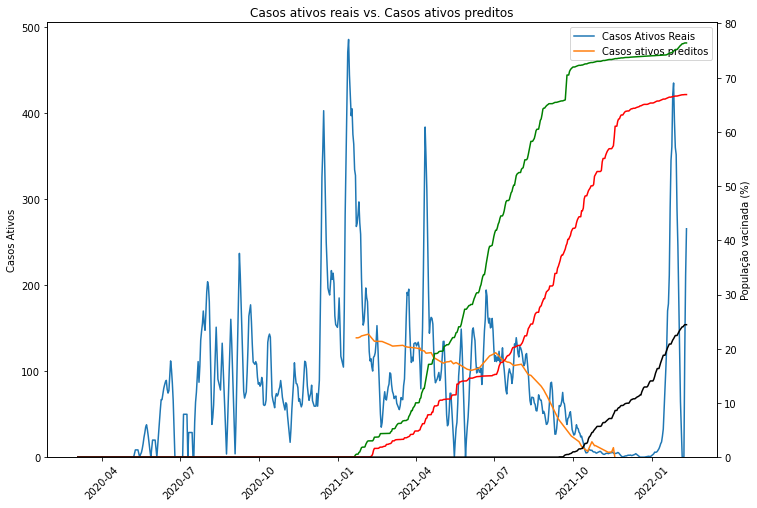

In [22]:
results = reg_lin(df_full)
plot_results(results, conf2)
ax = plt.gca().twinx()
ax.set_ylabel('População vacinada (%)')
ax.plot(df2['DATA'], df2['1ª Dose'], color='green')
ax.plot(df2['DATA'], df2['2ª Dose'], color='red')
ax.plot(df2['DATA'], df2['1º Reforço'], color='black')
plt.ylim(0)